In [123]:
import json
import random
from collections import defaultdict

# Súbory
input_file = 'synteticke_json_jazdy_enriched_full_osm4.jsonl'
output_file = 'synteticke_json_random_drivers.jsonl'

# Mapovanie vodičov na štýly
driver_profiles = {
    'driver_1': 'defenzívny',
    'driver_2': 'neutralný',
    'driver_3': 'defenzívny',
    'driver_4': 'agresívny',
    'driver_5': 'neutralný',
    'driver_6': 'agresívny',
    'driver_7': 'neutralný',
    'driver_8': 'defenzívny',
    'driver_9': 'agresívny',
}

# Invertuj: štýl → zoznam driverov
style_to_drivers = defaultdict(list)
for driver, style in driver_profiles.items():
    style_to_drivers[style].append(driver)

# Funkcia: vyber vodiča podľa štýlu jazdy
def assign_driver(jazda_style):
    if jazda_style == 'defenzívny':
        return random.choice(style_to_drivers['defenzívny'] + style_to_drivers['neutralný'])
    elif jazda_style == 'agresívny':
        return random.choice(style_to_drivers['agresívny'] + style_to_drivers['neutralný'])
    elif jazda_style == 'neutralný':
        return random.choice(list(driver_profiles.keys()))
    else:
        # fallback pre neznámy štýl
        return random.choice(list(driver_profiles.keys()))

# Spracovanie dát
with open(input_file, 'r', encoding='utf-8') as f_in, open(output_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        data = json.loads(line)

        jazda_style = data.get('driverType', 'neutralný')  # fallback ak chýba
        assigned_driver = assign_driver(jazda_style)

        data['ssoId'] = assigned_driver
        json.dump(data, f_out, ensure_ascii=False)
        f_out.write('\n')

print(f"✅ Súbor bol vytvorený: {output_file}")


✅ Súbor bol vytvorený: synteticke_json_random_drivers.jsonl


In [ ]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
from geopy.distance import geodesic

input_file = 'synteticke_json_random_drivers.jsonl'
output_file = 'kompletne_metriky_jazd.csv'

def process_ride(data):
    rec = data.get("records", [])
    ts = data.get("timestamp", 0)
    dt = datetime.utcfromtimestamp(ts)

    # Časové a kontextové premenné
    hour = dt.hour
    part_of_day = (
        'ranná špička' if 5 <= hour < 10 else
        'denná' if 10 <= hour < 17 else
        'večerná špička' if 17 <= hour < 21 else
        'nočná'
    )
    is_night = part_of_day == 'nočná'
    is_peak = part_of_day in ['ranná špička', 'večerná špička']
    day_of_week = dt.weekday()
    is_weekend = day_of_week >= 5

    speeds, accels, laterals, headings, incidents = [], [], [], [], []
    fuel_lvls, soc_lvls, locations, accel_times = [], [], [], []

    for r in rec:
        name, val = r.get("n"), r.get("v")
        t = r.get("t")
        try:
            if name == "SPEED":
                speeds.append(float(val))
            elif name == "LONGITUDINAL_ACCELERATION":
                accels.append(float(val))
                accel_times.append(t)
            elif name == "LATERAL_ACCELERATION":
                laterals.append(float(val))
            elif name == "HEADING":
                headings.append(float(val))
            elif name == "INCIDENT":
                incidents.append(int(val))
            elif name == "FUEL_LVL":
                fuel_lvls.append(float(val))
            elif name == "STATE_OF_CHARGE":
                soc_lvls.append(float(val))
            elif name == "PERSONALIZED_LOCATION":
                lat, lon = map(float, val.split(","))
                locations.append((lat, lon))
        except:
            continue

    # Výpočty metrík
    avg_speed = np.mean(speeds) if speeds else 0
    max_speed = np.max(speeds) if speeds else 0
    std_speed = np.std(speeds) if speeds else 0
    volatility = np.std(np.diff(speeds)) if len(speeds) > 1 else 0
    overspeed_count = sum(1 for s in speeds if s > 130)
    stops = sum(1 for s in speeds if s == 0)

    hard_accels = sum(1 for a in accels if a > 2.5)
    hard_brakes = sum(1 for a in accels if a < -3)
    jerk = np.mean(np.abs(np.diff(accels))) if len(accels) >= 2 else 0
    std_accel = np.std(accels) if accels else 0

    lateral_max = np.max(np.abs(laterals)) if laterals else 0
    direction_changes = sum(1 for i in range(1, len(headings)) if abs(headings[i] - headings[i - 1]) > 90)

    fuel_used = fuel_lvls[0] - fuel_lvls[-1] if len(fuel_lvls) >= 2 else 0
    soc_used = soc_lvls[0] - soc_lvls[-1] if len(soc_lvls) >= 2 else 0

    distance = 0
    for i in range(1, len(locations)):
        distance += geodesic(locations[i - 1], locations[i]).meters

    duration = (accel_times[-1] - accel_times[0]) if len(accel_times) >= 2 else 0

    return {
        "ssoId": data.get("ssoId"),
        "driverType": data.get("driverType"),
        "scenario": data.get("scenario"),
        "traffic": data.get("traffic"),
        "timestamp": ts,
        "hour": hour,
        "day_of_week": day_of_week,
        "is_weekend": is_weekend,
        "part_of_day": part_of_day,
        "is_peak": is_peak,
        "is_night": is_night,
        "weather_condition": data.get("weather", {}).get("condition"),
        "road_state": data.get("weather", {}).get("road_state"),
        "temperature": data.get("weather", {}).get("temperature"),
        "visibility": data.get("weather", {}).get("visibility"),
        "precipitation": data.get("weather", {}).get("precipitation"),
        "windspeed": data.get("weather", {}).get("windspeed"),
        "avg_speed": avg_speed,
        "max_speed": max_speed,
        "std_speed": std_speed,
        "volatility": volatility,
        "overspeed_count": overspeed_count,
        "stops": stops,
        "hard_accels": hard_accels,
        "hard_brakes": hard_brakes,
        "avg_jerk": jerk,
        "std_accel": std_accel,
        "lateral_peak": lateral_max,
        "direction_changes": direction_changes,
        "fuel_drop": fuel_used,
        "soc_drop": soc_used,
        "total_incidents": sum(incidents),
        "trip_duration_sec": duration,
        "distance_m": distance
    }

# Načítanie a spracovanie
results = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        results.append(process_ride(json.loads(line)))

# Uloženie
df = pd.DataFrame(results)
df.to_csv(output_file, index=False)
print(f"✅ Všetky metriky uložené v súbore: {output_file}")


✅ Všetky metriky uložené v súbore: kompletne_metriky_jazd.csv


In [125]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random

# 1. Načítaj dáta bez ssoId
df = pd.read_csv("kompletne_metriky_jazd.csv")  # <- tvoj vstupný súbor bez vodičov

# 2. Vypočítaj risk_score ako predtým
risk_features = [
    'hard_accels', 'hard_brakes', 'overspeed_count', 'total_incidents',
    'volatility', 'direction_changes', 'std_speed'
]
scaler = MinMaxScaler()
normalized = scaler.fit_transform(df[risk_features])
norm_df = pd.DataFrame(normalized, columns=risk_features)

weights = {
    'hard_accels': 0.15, 'hard_brakes': 0.15, 'overspeed_count': 0.1,
    'total_incidents': 0.3, 'volatility': 0.1,
    'direction_changes': 0.1, 'std_speed': 0.1
}

df['risk_score'] = sum(norm_df[col] * w for col, w in weights.items())

# 3. Rozdelenie jázd podľa rizikovosti
df_sorted = df.sort_values("risk_score")
n = len(df_sorted)
low_risk = df_sorted.iloc[:n//3]
medium_risk = df_sorted.iloc[n//3:2*n//3]
high_risk = df_sorted.iloc[2*n//3:]

# 4. Vodiči podľa profilu
drivers = {
    'defenzívny': ['driver_1', 'driver_3', 'driver_8'],
    'normálny': ['driver_2', 'driver_5', 'driver_7'],
    'agresívny': ['driver_4', 'driver_6','driver_9'],
}

# 5. Priraď vodičov
def assign_drivers(df_subset, driver_list):
    sso_ids = np.random.choice(driver_list, size=len(df_subset), replace=True)
    df_subset = df_subset.copy()
    df_subset["ssoId"] = sso_ids
    return df_subset

low = assign_drivers(low_risk, drivers['defenzívny'])
medium = assign_drivers(medium_risk, drivers['normálny'])
high = assign_drivers(high_risk, drivers['agresívny'])

# 6. Spojenie a uloženie
final_df = pd.concat([low, medium, high]).sample(frac=1, random_state=42).reset_index(drop=True)
final_df.to_csv("kompletne_metriky_jazd.csv", index=False)

print("✅ Jazdy boli inteligentne priradené vodičom a uložené ako 'kompletne_metriky_jazd.csv'")


✅ Jazdy boli inteligentne priradené vodičom a uložené ako 'kompletne_metriky_jazd.csv'


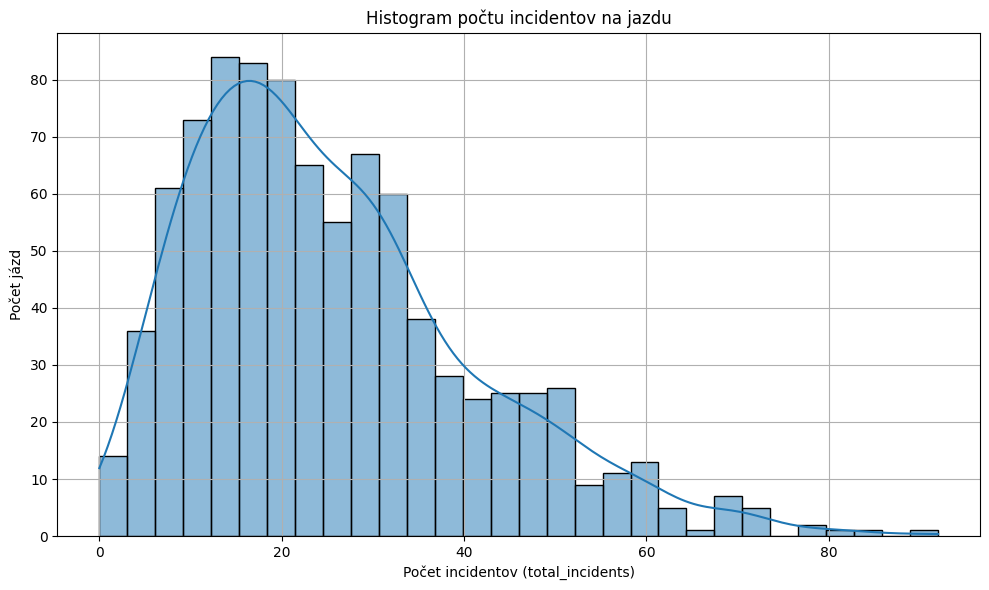

Popisné štatistiky pre total_incidents:
count    900.000000
mean      25.564444
std       15.438970
min        0.000000
25%       14.000000
50%       23.000000
75%       33.000000
max       92.000000
Name: total_incidents, dtype: float64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")  # ← zmeň na svoj aktuálny názov súboru

# 2. Histogram výskytu incidentov
plt.figure(figsize=(10, 6))
sns.histplot(df["total_incidents"], bins=30, kde=True)
plt.title("Histogram počtu incidentov na jazdu")
plt.xlabel("Počet incidentov (total_incidents)")
plt.ylabel("Počet jázd")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Výpis základných štatistík
print("Popisné štatistiky pre total_incidents:")
print(df["total_incidents"].describe())


In [25]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")

# 2. Odstránenie nenumerických premenných
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 3. Odstránenie total_incidents a odvodených cieľových premenných (ak existujú)
excluded = ['total_incidents', 'incident_risk_score', 'risk_score', 'safety_score', 'predicted_safety_score']
numerical_features = [col for col in numerical_cols if col not in excluded]

# 4. Odstránenie chýbajúcich hodnôt a prevod na float
X = df[numerical_features].dropna().astype(float)

# 5. Výpočet VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 6. Zoradenie podľa VIF
vif_data = vif_data.sort_values("VIF", ascending=False)
print(vif_data)


              Feature         VIF
0           timestamp  425.126185
18  direction_changes   35.836448
13        hard_accels   28.437054
14        hard_brakes   26.022256
8           max_speed   15.539895
7           avg_speed   15.065116
16          std_accel   13.856352
15           avg_jerk   11.878531
21  trip_duration_sec    7.791317
10         volatility    5.001969
22         distance_m    3.856097
9           std_speed    2.406110
4          visibility    1.753527
3         temperature    1.613520
11    overspeed_count    1.478788
1                hour    1.204261
17       lateral_peak    1.154941
2         day_of_week    1.146831
6           windspeed    1.113889
5       precipitation    1.088677
19          fuel_drop    1.029079
20           soc_drop    1.018186
12              stops         NaN


C:\Users\Kristián\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


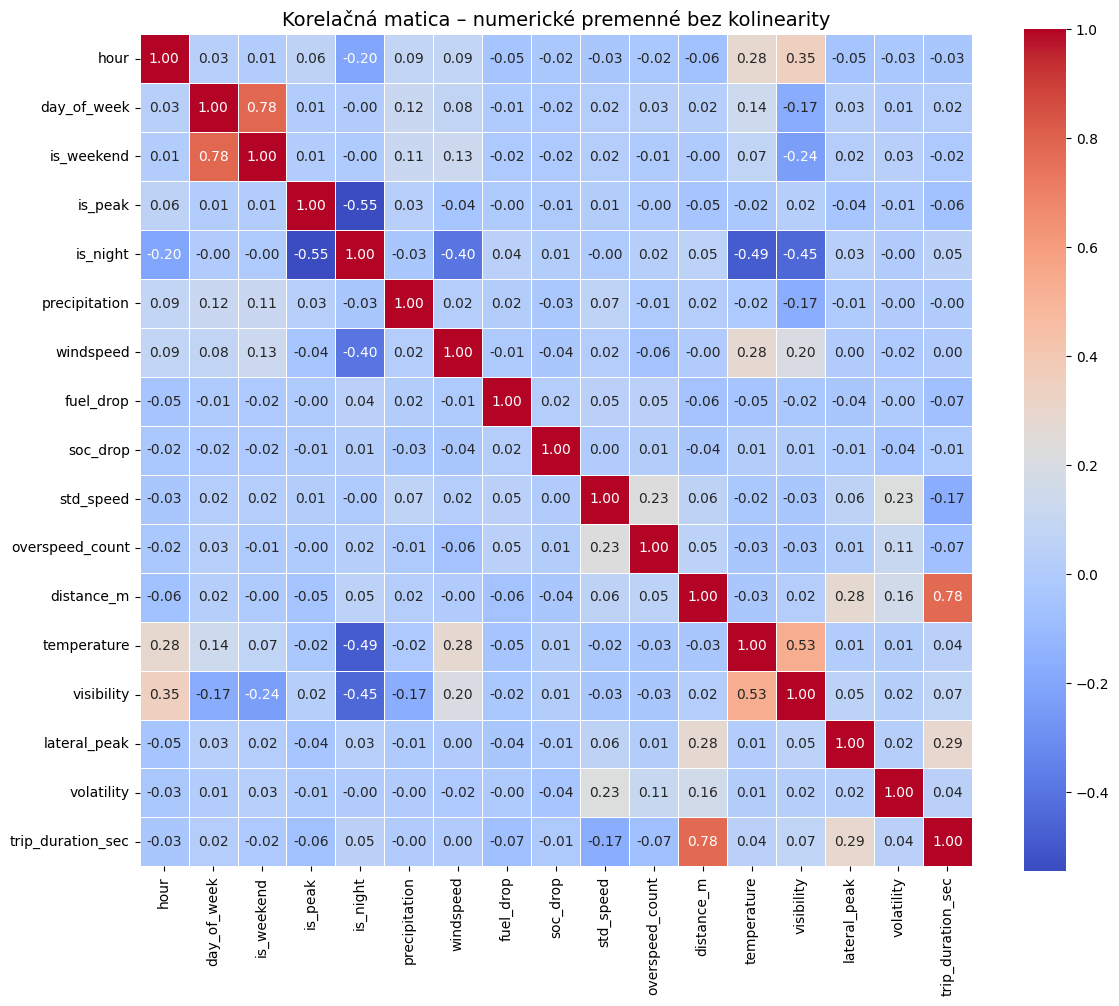

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")

# 2. Výber len numerických premenných z finálneho modelu
numerical_features =[
    'hour', 'day_of_week', 'is_weekend', 'is_peak', 'is_night',
    'precipitation', 'windspeed', 'fuel_drop', 'soc_drop',
    'std_speed', 'overspeed_count',"distance_m",
    'temperature', 'visibility', 'lateral_peak','volatility','trip_duration_sec'
]

# 3. Korelačná matica (Pearson)
corr_matrix = df[numerical_features].corr(method='pearson')

# 4. Vizualizácia
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Korelačná matica – numerické premenné bez kolinearity", fontsize=14)
plt.tight_layout()
plt.savefig("korelacna_matrica_vybrane_premenne.png")
plt.show()


RandomForest → MAE: 5.70 | RMSE: 7.09 | R²: 0.76
GradientBoosting → MAE: 6.02 | RMSE: 7.43 | R²: 0.73
LinearRegression → MAE: 7.12 | RMSE: 9.14 | R²: 0.60
SVR → MAE: 11.19 | RMSE: 14.13 | R²: 0.04
KNN → MAE: 9.68 | RMSE: 12.09 | R²: 0.29

Porovnanie modelov:
              Model        MAE       RMSE        R2
0      RandomForest   5.697267   7.090505  0.757085
1  GradientBoosting   6.015072   7.432315  0.733100
2  LinearRegression   7.116016   9.143035  0.596094
3               SVR  11.190854  14.130279  0.035280
4               KNN   9.680160  12.091487  0.293586


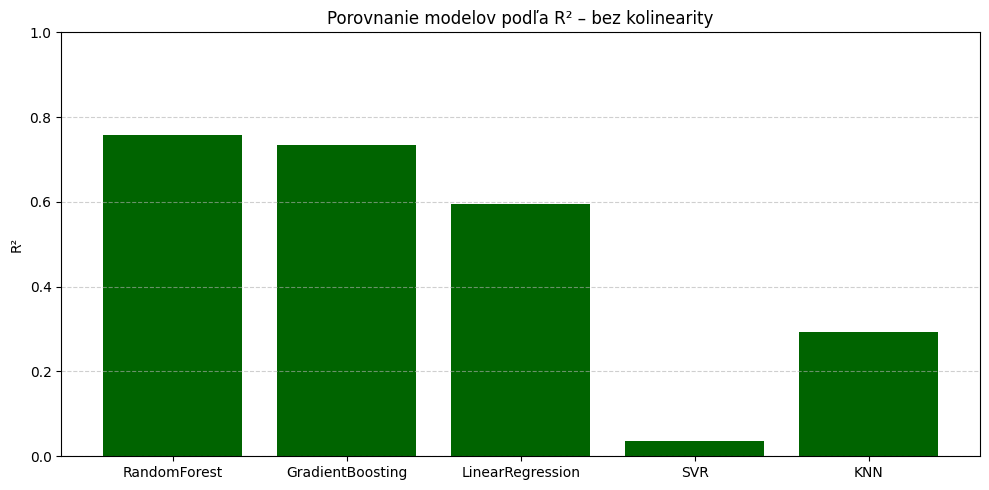

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")

# 2. Výpočet incident risk skóre (log škálovanie)
df["incident_risk_score"] = np.log1p(df["total_incidents"]) / np.log1p(df["total_incidents"].max()) * 100

# 3. Výber premenných bez multikolinearity
features = [
    'hour', 'day_of_week', 'is_weekend', 'is_peak', 'is_night',
    'precipitation', 'windspeed', 'fuel_drop', 'soc_drop',
    'std_speed', 'overspeed_count',
    'temperature', 'visibility', 'lateral_peak','volatility','trip_duration_sec'
]

# 4. Rozdelenie podľa typu dát
categorical = df[features].select_dtypes(include='object').columns.tolist()
numerical = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

# 5. Predspracovanie
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numerical)
])

# 6. Rozdelenie dát
X = df[features]
y = df["incident_risk_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Modely na porovnanie
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor()
}

results = []

# 8. Tréning a vyhodnotenie
for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append((name, mae, rmse, r2))
    print(f"{name} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")

# 9. Výsledky tabuľkovo
results_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R2"])
print("\nPorovnanie modelov:")
print(results_df)

# 10. Vizualizácia R²
plt.figure(figsize=(10, 5))
plt.bar(results_df["Model"], results_df["R2"], color="darkgreen")
plt.title("Porovnanie modelov podľa R² – bez kolinearity")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("porovnanie_modelov_bez_kolinearity.png")
plt.show()


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Najlepšie parametre: {'regressor__max_depth': 16, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
MAE: 6.20
RMSE: 7.62
R²: 0.72


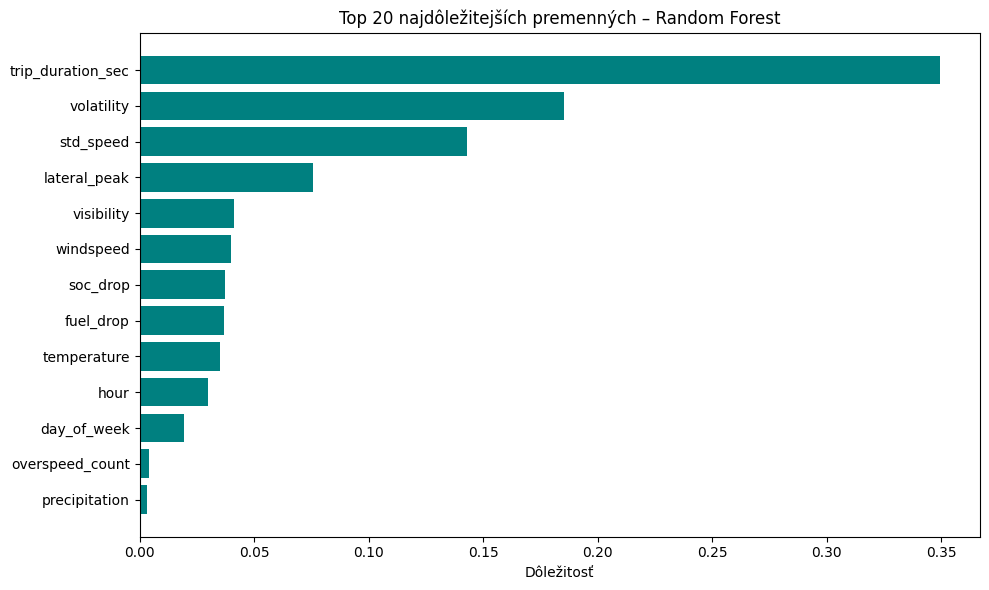

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")

# 2. Výpočet incident risk skóre
df["incident_risk_score"] = np.log1p(df["total_incidents"]) / np.log1p(df["total_incidents"].max()) * 100

# 3. Výber premenných
features = [
    'hour', 'day_of_week', 'is_weekend', 'is_peak', 'is_night',
    'precipitation', 'windspeed', 'fuel_drop', 'soc_drop',
    'std_speed', 'overspeed_count',
    'temperature', 'visibility', 'lateral_peak', 'volatility', 'trip_duration_sec'
]

# 4. Typové rozdelenie
categorical = df[features].select_dtypes(include='object').columns.tolist()
numerical = df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

# 5. Predspracovanie
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numerical)
])

# 6. Rozdelenie dát
X = df[categorical + numerical]
y = df["incident_risk_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Pipeline
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# 8. GridSearch parametre
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [8, 12, 16],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 9. Vyhodnotenie
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Najlepšie parametre:", grid_search.best_params_)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# 10. Feature importance
rf_model = best_model.named_steps['regressor']
preprocessor = best_model.named_steps['preprocessor']
preprocessor.fit(X_train)

feature_names_cat = []
if categorical:
    encoder = preprocessor.named_transformers_['cat']
    feature_names_cat = encoder.get_feature_names_out(categorical)

feature_names = np.concatenate([feature_names_cat, numerical])
importances = rf_model.feature_importances_

feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# 11. Vizualizácia najdôležitejších premenných
top_features = feature_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1], color='teal')
plt.xlabel("Dôležitosť")
plt.title("Top 20 najdôležitejších premenných – Random Forest")
plt.tight_layout()
plt.savefig("feature_importance_rf.png")
plt.show()


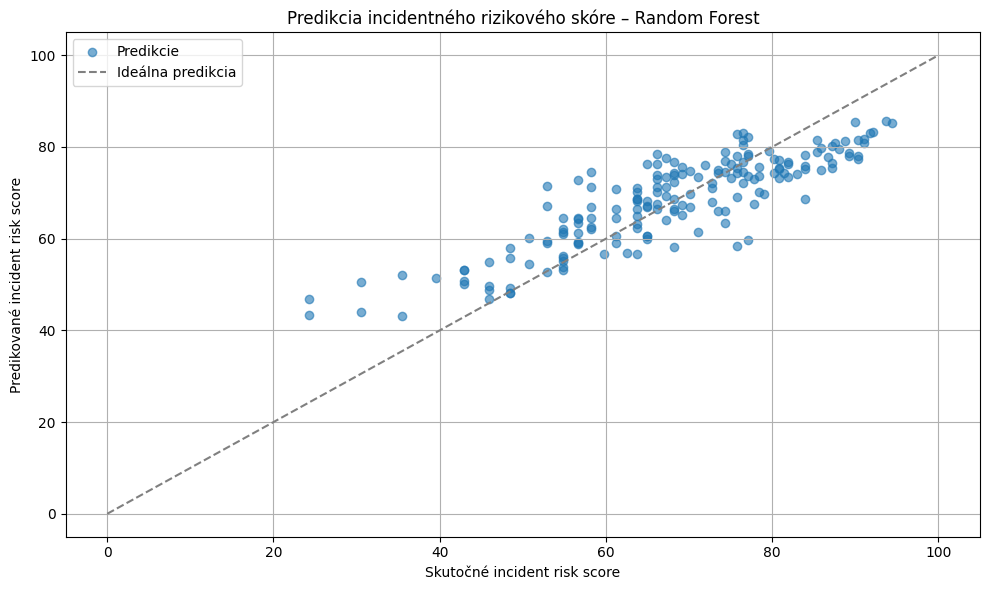

In [37]:
import matplotlib.pyplot as plt

# 1. Vizualizácia predikcie Random Forest modelu
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label="Predikcie")
plt.plot([0, 100], [0, 100], '--', color='gray', label="Ideálna predikcia")
plt.xlabel("Skutočné incident risk score")
plt.ylabel("Predikované incident risk score")
plt.title("Predikcia incidentného rizikového skóre – Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("incident_risk_score_prediction_rf.png")
plt.show()


In [38]:
import pandas as pd

# Predpoklad: premenné y_pred (predikcia), y_test (reálne skóre) a X_test existujú
# Ak máš index pôvodných dát, pripoj späť identifikátor (napr. ssoId)

# 1. Reset indexov
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

# 2. Spojenie predikcií a skutočných hodnôt
results_df = pd.DataFrame({
    "predicted_incident_risk_score": y_pred,
    "actual_incident_risk_score": y_test_reset
})

# 3. Pripojenie identifikátora (ak ho máš v pôvodnom DataFrame)
if "ssoId" in df.columns:
    results_df["ssoId"] = df.loc[X_test.index, "ssoId"].values

# 4. Uloženie do CSV
results_df.to_csv("predikovane_jazdy_randomforest.csv", index=False)
print("✅ Predikované výsledky boli uložené do 'predikovane_jazdy_randomforest.csv'")


✅ Predikované výsledky boli uložené do 'predikovane_jazdy_randomforest.csv'


In [51]:
import pandas as pd

# 1. Načítanie pôvodných dát a predikcií
df_all = pd.read_csv("kompletne_metriky_jazd.csv")
df_pred = pd.read_csv("predikovane_jazdy_randomforest.csv")

# 2. Spojenie podľa 'ssoId'
df_joined = pd.merge(df_all, df_pred[['ssoId', 'predicted_incident_risk_score']], on='ssoId', how='left')

# 3. Uloženie výsledného súboru
df_joined.to_csv("jazdy_ai_skore_randomforest_full_enriched.csv", index=False)


                                      MAE      RMSE        R2
Model s exogénnymi premennými    6.404555  7.832425  0.703590
Model bez exogénnych premenných  6.001601  7.420554  0.733944


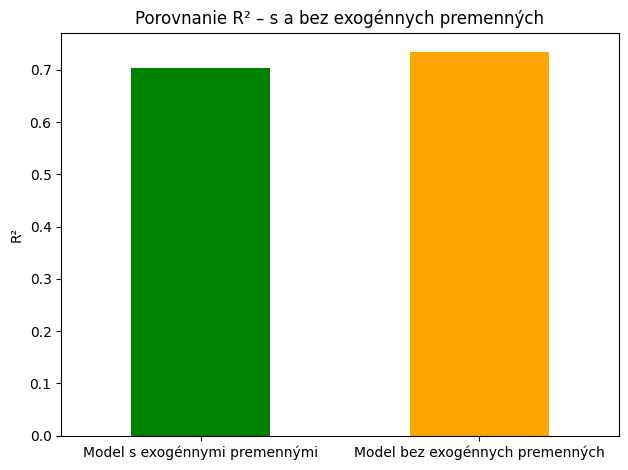

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Načítanie dát
df = pd.read_csv("kompletne_metriky_jazd.csv")

# 2. Výpočet incident risk skóre
df["incident_risk_score"] = np.log1p(df["total_incidents"]) / np.log1p(df["total_incidents"].max()) * 100

# 3. Definovanie premenných
all_features = [
    'hour', 'day_of_week', 'is_weekend', 'is_peak', 'is_night',
    'precipitation', 'windspeed', 'fuel_drop', 'soc_drop',
    'std_speed', 'overspeed_count',
    'temperature', 'visibility', 'lateral_peak', 'volatility', 'trip_duration_sec'
]

exogenous = ['precipitation', 'windspeed', 'temperature', 'visibility']
features_with_exo = all_features
features_without_exo = [f for f in all_features if f not in exogenous]

# 4. Funkcia na tréning modelu
def train_rf_model(features):
    X = df[features]
    y = df["incident_risk_score"]
    categorical = X.select_dtypes(include='object').columns.tolist()
    numerical = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numerical)
    ])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42))
    ])

    param_grid = {
        'regressor__n_estimators': [100],
        'regressor__max_depth': [12],
        'regressor__min_samples_split': [2],
        'regressor__min_samples_leaf': [1],
        'regressor__max_features': ['sqrt']
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    grid = GridSearchCV(pipe, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    return {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

# 5. Spustenie tréningu pre obe verzie
results = {
    "Model s exogénnymi premennými": train_rf_model(features_with_exo),
    "Model bez exogénnych premenných": train_rf_model(features_without_exo)
}

# 6. Zobrazenie výsledkov
results_df = pd.DataFrame(results).T
print(results_df)

# 7. Vizualizácia rozdielu
results_df["R2"].plot(kind="bar", color=["green", "orange"])
plt.title("Porovnanie R² – s a bez exogénnych premenných")
plt.ylabel("R²")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("r2_comparison_rf_exo_vs_noexo.png")
plt.show()
